<a href="https://colab.research.google.com/github/ioannaoiko/Deep_Learning_for_NLP/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 24.1 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
# % matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Imports
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
from textblob import Word
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

import os
import numpy as np

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import sys



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Loading the dataset
df = pd.read_csv("./imdb-reviews.csv", sep='\t')
df.describe()

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


In [ ]:
#Check for null values
#In this case there are no missing values
df.isnull().sum()

url       0
rating    0
review    0
dtype: int64

In [ ]:
#data preprocessing function
def preprocessing(review):
  review = review.lower()
  review = review.replace('http\S+|www.\S+|https\S+','') #removing urls
  review = review.replace('<br />', '') #removing <br>
  review = review.replace('...', '')
  review = word_tokenize(review) #tokenization
  review = " ".join(review)

  review = ' '.join([word for word in review.split() if word not in punctuation])
  review = ' '.join([word for word in review.split() if word not in stop_words])
  review = ' '.join([word for word in review.split() if not word.isdigit()])

  review = ' '. join([word for word in review.split() if "'" not in word])
  review = ' '. join([word for word in review.split() if "`" not in word])

  return "".join(Word(word).lemmatize() for word in review)

In [ ]:
#adding boolean sentiment column to the dataset
df['sentiment'] = df['rating'] >=7

In [ ]:
df['review'] = df['review'].apply(preprocessing)

In [ ]:
df = df.drop_duplicates('review')

In [ ]:
#splitting dataset into training and validation data
training_data = df.sample(frac=0.8)
validation_data = df.drop(training_data.index)

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
class ReviewDataset(Dataset):
  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, index):
    review = str(self.reviews[index])
    sentiment = self.sentiments[index]

    encoding = self.tokenizer.encode_plus(
      review,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      max_length=self.max_len,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt'
    )

    return {
      'reviews': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

In [ ]:
max_len = 512

In [ ]:
train_dataset = ReviewDataset(training_data.review.values, training_data.sentiment.values, tokenizer, max_len)
train_data = DataLoader(train_dataset, batch_size=16)

validation_dataset = ReviewDataset(validation_data.review.values, validation_data.sentiment.values, tokenizer, max_len)
valid_data = DataLoader(validation_dataset, batch_size=16)


In [ ]:
class Classifier(nn.Module):
  def __init__(self, num_of_classes, pretrained_model='bert-base-uncased'):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(pretrained_model, return_dict=False)
    self.out = nn.Linear(self.bert.config.hidden_size, num_of_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, output = self.bert( input_ids=input_ids, attention_mask=attention_mask)
    output = self.out(output)
    return self.softmax(output)

In [ ]:
model = Classifier(2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), learning_rate, correct_bias=False)
loss_function = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
EPOCHS = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(train_data)*EPOCHS)

**Training**

In [ ]:
train_accuracies = []
val_accuracies = []
maximum = 0
epochs = []
for epoch in range(EPOCHS):
  epochs.append(epoch)
  model = model.train()
  train_losses = []
  val_losses = []
  train_valid = 0
  val_valid = 0
  train_size = 0
  val_size = 0
  for review in train_data:
    input_ids = review["input_ids"].to(device)
    attention_mask = review["attention_mask"].to(device)
    sentiments = review["sentiments"].to(device)
    # print(sentiments.shape)

    output = model(input_ids=input_ids, attention_mask=attention_mask)
    # print(output.shape)
    out, pred = torch.max(output, dim=1)
    loss = loss_function(output, sentiments)
    train_losses.append(loss.item())

    train_valid += torch.sum(sentiments == pred)
    train_size += sentiments.size(0)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  train_accuracies.append(train_valid.cpu().double()/train_size)

  print("Epoch {} : train accuracy: {}, train loss: {}".format(epoch, train_valid.double()/train_size, np.sum(train_losses)/len(train_data)))

  model = model.eval()
  with torch.no_grad():
    for review in valid_data:
      input_ids = review["input_ids"].to(device)
      attention_mask = review["attention_mask"].to(device)
      sentiments = review["sentiments"].to(device)

      output = model(input_ids=input_ids, attention_mask=attention_mask)

      out, pred = torch.max(output, dim=1)
      loss = loss_function(output, sentiments)
      val_losses.append(loss.item())

      val_valid += torch.sum(sentiments == pred)
      val_size += sentiments.size(0)

  val_accuracies.append(val_valid.cpu().double()/val_size)
  if val_valid.double()/val_size > maximum:
    torch.save(model.state_dict(), 'myModel.pt')
    maximum = val_valid.double()/val_size
  print("Epoch {} : validation accuracy: {}, validation loss: {}".format(epoch, val_valid.double()/val_size, np.sum(val_losses)/len(valid_data)))






/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-13-1d79fb7022d2>:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'sentiments': torch.tensor(sentiment, dtype=torch.long)


Epoch 0 : train accuracy: 0.8673457964849435, train loss: 0.4417997228987215
Epoch 0 : validation accuracy: 0.8802194111720586, validation loss: 0.42924340023977386
Epoch 1 : train accuracy: 0.9164614351281763, train loss: 0.39491315132662347
Epoch 1 : validation accuracy: 0.8943244150901153, validation loss: 0.41622914600457617
Epoch 2 : train accuracy: 0.9332810925780812, train loss: 0.3788500618166228
Epoch 2 : validation accuracy: 0.905071084741968, validation loss: 0.4071144932924315


In [ ]:
torch.cuda.empty_cache()

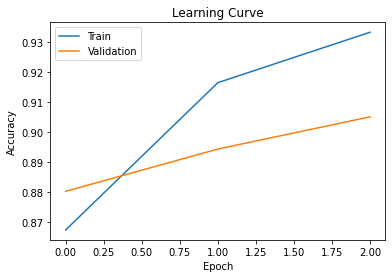

In [ ]:
plt.title("Learning Curve")
plt.plot(epochs, train_accuracies, label="Train")
plt.plot(epochs, val_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
model = model.eval()
targets = []
predictions = []
with torch.no_grad():
  for review in valid_data:
    input_ids = review["input_ids"].to(device)
    attention_mask = review["attention_mask"].to(device)
    sentiments = review["sentiments"].to(device)
    targets.append(sentiments)

    output = model(input_ids=input_ids, attention_mask=attention_mask)

    out, pred = torch.max(output, dim=1)
    predictions.append(pred.cpu())

    val_valid += torch.sum(pred == sentiments)

  targets = torch.cat(targets).cpu().numpy()
  predictions = torch.cat(predictions).numpy()

  print(classification_report(targets, predictions))

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-13-1d79fb7022d2>:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'sentiments': torch.tensor(sentiment, dtype=torch.long)


              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4470
           1       0.90      0.91      0.91      4463

    accuracy                           0.91      8933
   macro avg       0.91      0.91      0.91      8933
weighted avg       0.91      0.91      0.91      8933



**You can use this next part for testing**

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=edothavaleistoidtoulink'
output_file = 'model.pt'
gdown.download(url, output_file, quiet=False)
model = model.eval()

#Loading the test dataset
test_data = pd.read_csv("insert test dataset path here", sep='\t')

targets = []
predictions = []
with torch.no_grad():
  for review in test_data:
    input_ids = review["input_ids"].to(device)
    attention_mask = review["attention_mask"].to(device)
    sentiments = review["sentiments"].to(device)
    targets.append(sentiments)

    output = model(input_ids=input_ids, attention_mask=attention_mask)

    out, pred = torch.max(output, dim=1)
    predictions.append(pred.cpu())

    val_valid += torch.sum(pred == sentiments)

  targets = torch.cat(targets).cpu().numpy()
  predictions = torch.cat(predictions).numpy()

  print(classification_report(targets, predictions))